In [ ]:
!pip install pyspark
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.ml import Pipeline
from pyspark.sql.functions import countDistinct, split, when, desc
from pyspark.ml.feature import HashingTF, Tokenizer, VectorAssembler,StringIndexer, StandardScaler
from pyspark.ml.clustering import BisectingKMeans, KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark = SparkSession.builder \
    .appName("ColabSpark") \
    .getOrCreate()

path = '/content/drive/Shareddrives/DDAM/Datasets aggiornati/df_filled.csv'

In [ ]:
data = spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
data.show()

+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+
|    DR_NO| Date Rptd|  DATE OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 3|Crm Cd 4|           LOCATION|    LAT|      LON|           TIME OCC|time_of_day|season|Crm Cd 1|Crm Cd 2|
+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+-------------------+-------+---------

In [ ]:
data.printSchema()

root
 |-- DR_NO: integer (nullable = true)
 |-- Date Rptd: date (nullable = true)
 |-- DATE OCC: date (nullable = true)
 |-- AREA: integer (nullable = true)
 |-- AREA NAME: string (nullable = true)
 |-- Rpt Dist No: integer (nullable = true)
 |-- Part 1-2: integer (nullable = true)
 |-- Crm Cd Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict Age: integer (nullable = true)
 |-- Vict Sex: string (nullable = true)
 |-- Vict Descent: string (nullable = true)
 |-- Premis Cd: integer (nullable = true)
 |-- Premis Desc: string (nullable = true)
 |-- Weapon Used Cd: integer (nullable = true)
 |-- Weapon Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status Desc: string (nullable = true)
 |-- Crm Cd 3: integer (nullable = true)
 |-- Crm Cd 4: integer (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- TIME OCC: timestamp (nullable = true)
 |-- time_of_day: s

# DATA PREPARATION  
#### Values to use for clustering:  
- sex: to be converted to int <br>  
- Time Of Day: to be converted to int <br>  
- status: to be converted to int <br>  
- seasons: to be converted to int <br>  
- area: <br>  
- part 1-2: <br>  
- vict age <br>  
- Weapon Used Cd: <br>  
- Crm Cd 1  


In [ ]:
# SEASON AND STATUS ENCODING
indexer_season = StringIndexer(inputCol="season", outputCol="season_encoded")
indexer_status = StringIndexer(inputCol="Status", outputCol="status_encoded")

pipeline = Pipeline(stages=[indexer_season, indexer_status])

model = pipeline.fit(data)
df = model.transform(data)

df.select("season", "season_encoded", "Status", "status_encoded").show()


+------+--------------+------+--------------+
|season|season_encoded|Status|status_encoded|
+------+--------------+------+--------------+
|summer|           2.0|    IC|           0.0|
|autumn|           3.0|    IC|           0.0|
|winter|           1.0|    IC|           0.0|
|winter|           1.0|    IC|           0.0|
|autumn|           3.0|    IC|           0.0|
|summer|           2.0|    IC|           0.0|
|winter|           1.0|    IC|           0.0|
|autumn|           3.0|    IC|           0.0|
|spring|           0.0|    AA|           2.0|
|autumn|           3.0|    IC|           0.0|
|spring|           0.0|    AO|           1.0|
|autumn|           3.0|    AO|           1.0|
|spring|           0.0|    IC|           0.0|
|winter|           1.0|    AO|           1.0|
|summer|           2.0|    IC|           0.0|
|spring|           0.0|    IC|           0.0|
|summer|           2.0|    IC|           0.0|
|winter|           1.0|    IC|           0.0|
|winter|           1.0|    IC|    

In [ ]:
#SEX AND TIME ECODING
df = df.withColumn("sex_encoded", when(df["Vict Sex"] == "M", 1).otherwise(0))

df = df.withColumn("time_encoded", when(df["time_of_day"] == "night", 0).otherwise(1))

In [ ]:
# HASHING Crm Cd Desc

tokenizer = Tokenizer(inputCol="Crm Cd Desc", outputCol="Crm Cd Desc_tokens")
df = tokenizer.transform(df)

hashing = HashingTF(inputCol="Crm Cd Desc_tokens", outputCol="Crm Cd Hash", numFeatures=100)
df = hashing.transform(df)


140


In [ ]:
# Representation of the data as a single vector
assembler = VectorAssembler(inputCols=["status_encoded", "season_encoded", "Crm Cd Hash","sex_encoded","time_encoded","Part 1-2","AREA","Vict Age","Weapon Used Cd"], outputCol="features")
df = assembler.transform(df)


In [ ]:
# Standardization of the features to use fot the clustering
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df)

df = scaler_model.transform(df)

# BISECTING KMEANS

#### Ricerca del K ottimale:

/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


k=5                         SSE: 90443372.58169723         SILHOUETTE: -0.0105
k=10                        SSE: 77092217.97156218         SILHOUETTE: 0.0372
k=12                        SSE: 72393174.71717736         SILHOUETTE: 0.1554
k=15                        SSE: 67425066.6983982          SILHOUETTE: 0.2784
k=17                        SSE: 63323806.98013969         SILHOUETTE: 0.3746
k=20                        SSE: 61505121.09503245         SILHOUETTE: 0.3838
k=22                        SSE: 62059978.456918314        SILHOUETTE: 0.3180
k=25                        SSE: 60044734.39033382         SILHOUETTE: 0.3190


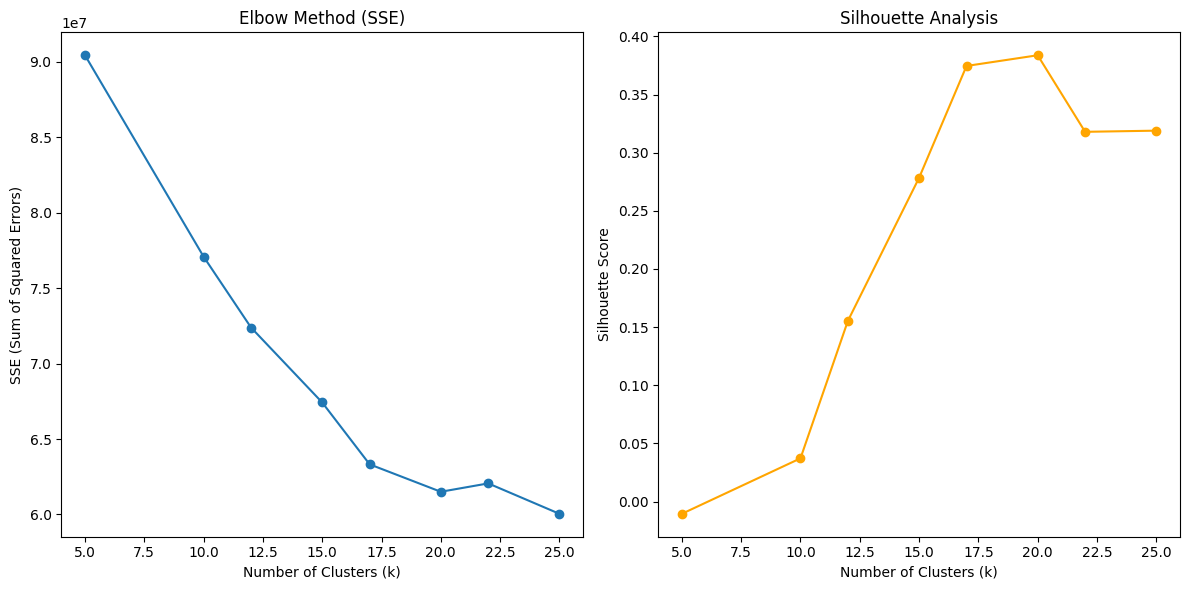

In [ ]:
numbers = [5, 10, 12, 15, 17, 20, 22, 25]

sse = []
silhouette_scores = []

for k in numbers:
    bkm = BisectingKMeans(k=k, seed=42, featuresCol="scaled_features")
    model = bkm.fit(df)

    current_sse = model.computeCost(df)
    sse.append(current_sse)

    predictions = model.transform(df)
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")
    current_silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(current_silhouette)
    print(f"k={k:<25} SSE: {current_sse:<25} SILHOUETTE: {current_silhouette:.4f}")

# SSE (Sum of Squared Errors)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(numbers, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method (SSE)')

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(numbers, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [ ]:
optimal_k = 17

bkm = BisectingKMeans(k=optimal_k, seed=42, featuresCol="scaled_features")
final_modelBKM = bkm.fit(df)

final_predictionsBKM = final_modelBKM.transform(df)

sse = final_modelBKM.computeCost(df)

# Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(final_predictionsBKM)

print(f"Performace of the model with k={optimal_k}:")
print(f"- SSE (Sum of Squared Errors): {sse}")
print(f"- Silhouette Score: {silhouette_score:.4f}")


/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


Performace of the model with k=17:
- SSE (Sum of Squared Errors): 63323806.98013969
- Silhouette Score: 0.3746


# KMeans

k=5                         SSE: 85895745.12622365         SILHOUETTE: 0.0761
k=10                        SSE: 78794866.65787575         SILHOUETTE: -0.0100
k=12                        SSE: 72927894.02899712         SILHOUETTE: 0.0892
k=15                        SSE: 64562311.5211703          SILHOUETTE: 0.1733
k=17                        SSE: 64384766.21878193         SILHOUETTE: 0.1395
k=20                        SSE: 56884295.05630367         SILHOUETTE: 0.2394
k=22                        SSE: 56690270.2158396          SILHOUETTE: 0.2259
k=25                        SSE: 49105304.15456928         SILHOUETTE: 0.3349


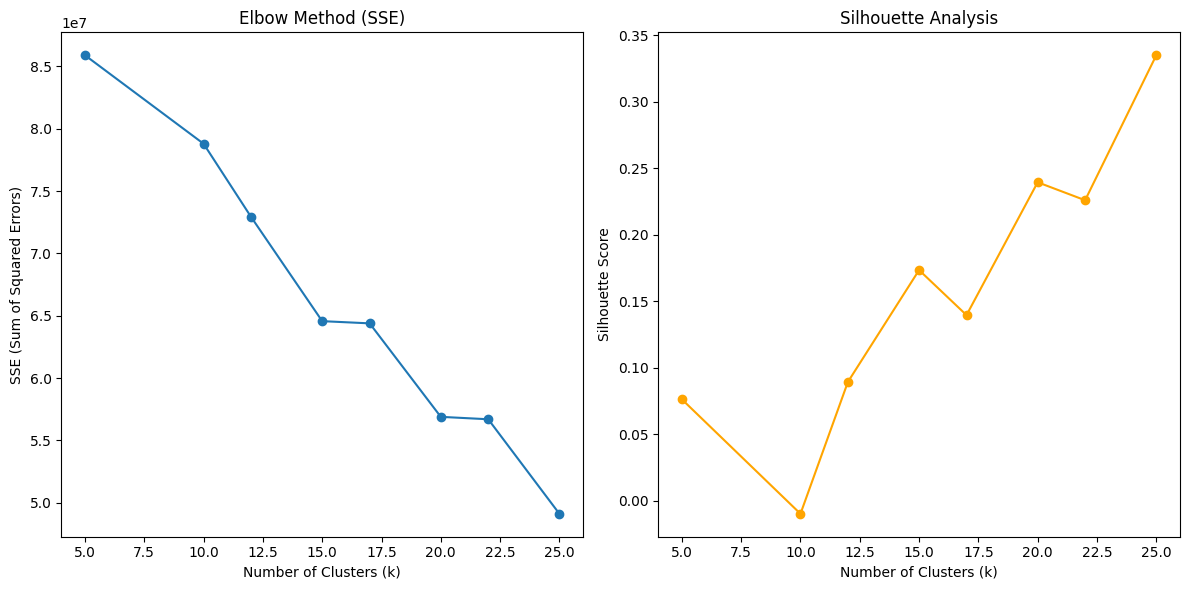

In [ ]:
numbers = [5, 10, 12, 15, 17, 20, 22, 25]

sse = []
silhouette_scores = []

for k in numbers:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaled_features")
    model = kmeans.fit(df)

    current_sse = model.summary.trainingCost  # Access trainingCost from summary
    sse.append(current_sse)

    predictions = model.transform(df)
    evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")
    current_silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(current_silhouette)
    print(f"k={k:<25} SSE: {current_sse:<25} SILHOUETTE: {current_silhouette:.4f}")

# SSE (Sum of Squared Errors)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(numbers, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method (SSE)')

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(numbers, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [ ]:
optimal_k = 20
kmeans = KMeans(k=optimal_k, seed=42, featuresCol="scaled_features")
final_modelKM = kmeans.fit(df)
final_predictionsKM = final_modelKM.transform(df)

sse = final_modelKM.summary.trainingCost

evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(final_predictionsKM)

print(f"Performace of the model with k={optimal_k}:")
print(f"- SSE (Sum of Squared Errors): {sse}")
print(f"- Silhouette Score: {silhouette_score:.4f}")

Performace of the model with k=17:
- SSE (Sum of Squared Errors): 64384766.21878193
- Silhouette Score: 0.1395


#RESULT ANALYSIS OF THE BEST CLUSTERING MODEL

In [ ]:
final_predictionsBKM.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|        12| 31022|
|         1| 45362|
|        13| 61142|
|         6| 23878|
|        16| 61551|
|         3| 24938|
|         5| 55487|
|        15|121928|
|         9|126575|
|         4| 39766|
|         8| 38028|
|         7| 59678|
|        10|117390|
|        11| 44977|
|        14|  6062|
|         2| 22604|
|         0|102250|
+----------+------+



In [ ]:
final_predictionsBKM.groupBy("season", "prediction").count().orderBy('season',desc('count')).show()

+------+----------+-----+
|season|prediction|count|
+------+----------+-----+
|autumn|         9|29076|
|autumn|        10|27680|
|autumn|        15|26992|
|autumn|         0|24346|
|autumn|        16|14510|
|autumn|        13|13710|
|autumn|         7|13611|
|autumn|         5|13388|
|autumn|        11|10532|
|autumn|         1|10452|
|autumn|         4| 9153|
|autumn|         8| 8827|
|autumn|        12| 7447|
|autumn|         6| 5598|
|autumn|         3| 5595|
|autumn|         2| 5304|
|autumn|        14| 1416|
|spring|         9|32622|
|spring|        15|31973|
|spring|        10|30126|
+------+----------+-----+
only showing top 20 rows



In [ ]:
final_predictionsBKM.groupBy("Crm Cd Desc", "prediction").count().orderBy('prediction',desc('count')).show(1500,truncate=False)

+--------------------------------------------------------+----------+------+
|Crm Cd Desc                                             |prediction|count |
+--------------------------------------------------------+----------+------+
|BATTERY - SIMPLE ASSAULT                                |0         |74688 |
|BRANDISH WEAPON                                         |0         |14512 |
|OTHER ASSAULT                                           |0         |4244  |
|THEFT, PERSON                                           |0         |4145  |
|DISTURBING THE PEACE                                    |0         |1511  |
|INDECENT EXPOSURE                                       |0         |1190  |
|THROWING OBJECT AT MOVING VEHICLE                       |0         |740   |
|UNAUTHORIZED COMPUTER ACCESS                            |0         |522   |
|BATTERY ON A FIREFIGHTER                                |0         |256   |
|PURSE SNATCHING                                         |0         |108   |

## DATA VISUALIZATION
#### BARPLOT

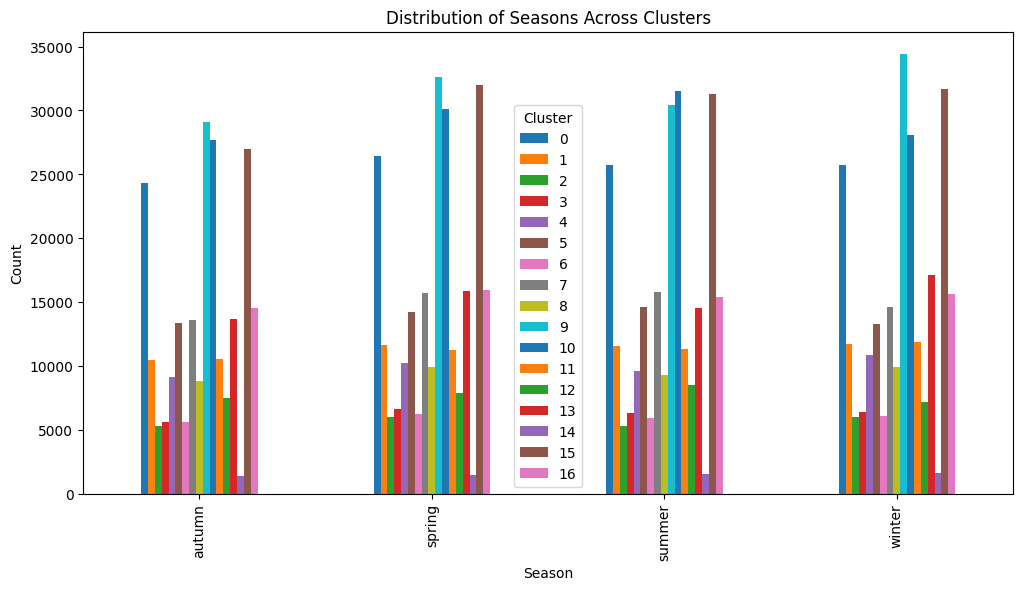

In [ ]:
grouped_data = final_predictionsBKM.groupBy("prediction", "season").count().orderBy("prediction").toPandas()

grouped_data.pivot(index="season", columns="prediction", values="count").plot(kind="bar", figsize=(12, 6))
plt.title("Distribution of Seasons Across Clusters")
plt.xlabel("Season")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.show()

#### Heatmaps

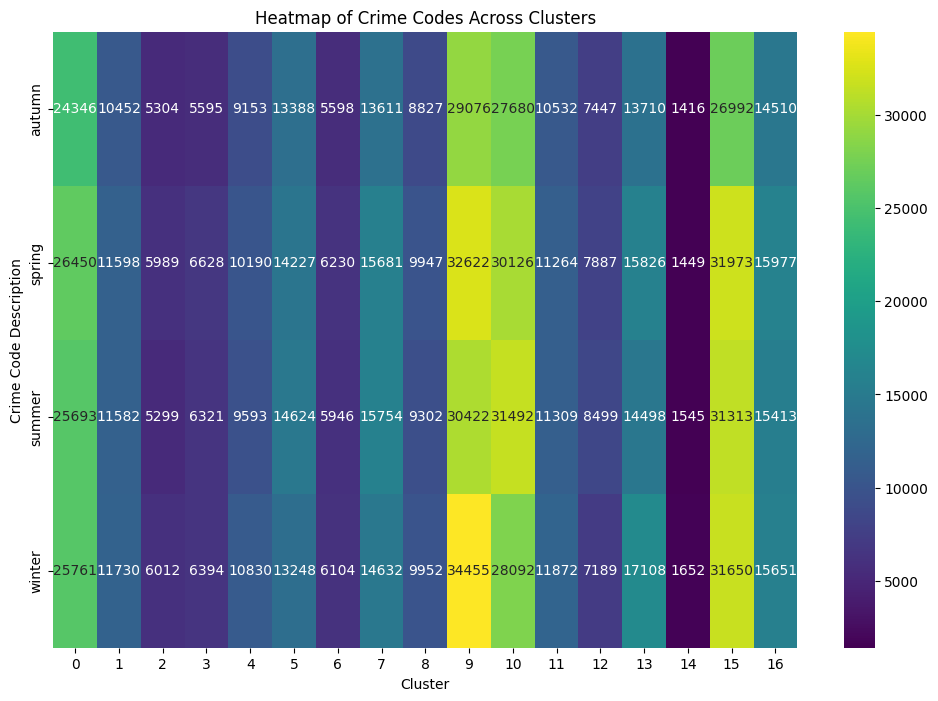

In [ ]:
import seaborn as sns
import pandas as pd

heatmap_data = final_predictionsBKM.groupBy("prediction", "season").count().toPandas()

heatmap_pivot = heatmap_data.pivot(index="season", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt="g", cmap="viridis")
plt.title("Heatmap of Crime Codes Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Crime Code Description")
plt.show()